<a href="https://colab.research.google.com/github/enzoampil/data-science-demos/blob/master/covid19/covid_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Authentication



In [0]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

# Access the COVID-19 PH data

Make sure you can access the spreadsheet from this [link](https://docs.google.com/spreadsheets/d/16g_PUxKYMC0XjeEKF6FPUBq2-pFgmTkHoj5lbVrGLhE/edit?fbclid=IwAR1qRr3hTxSiQ8KdymZiIQfPX4CpSA4VezpNKqXIPCIMQI1H3xMTGJ16lMs#gid=0)

In [0]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime, timedelta

In [0]:
def sheets_to_df(sheet_name):
    sheet_lol = gc.open(sheet_name).sheet1.get_all_values()
    return pd.DataFrame(sheet_lol[1:], columns=sheet_lol[0])

In [0]:
data = sheets_to_df('COVID-19 Philippines')

In [0]:
data

,Case No.,Sex,Age,Nationality,History of Travel / Exposure,Travel History,Epi_Link,Date of Onset of Symptoms,Date of Admission,Date of Lab Confirmation,Date of Announcement to the Public,Admission / Consultation,Residence in the Philippines,Symptoms,Other disease,Status,Health Status,Date of Final Status (recovered/expired),Final Diagnosis,Age Group,Location,Latitude,Longitude,Residence Lat,Residence Long
0,PH001,F,38,Chinese,Yes (China); Wife of PH02,China,Wife of PH2,21-Jan-20,25-Jan-20,30-Jan-20,30-Jan-2020,San Lazaro Hospital,None,,,Recovered,Recovered,8-Feb-2020,,31 - 40,San Lazaro Hospital,14.613754,120.980815,14.6138,120.981
1,PH002,M,44,Chinese,Yes (China); Husband of PH1,China,Husband of PH1,18-Jan-20,25-Jan-20,30-Jan-20,2-Feb-2020,San Lazaro Hospital,None,"Fever, Cough, Sore throat",,Expired,Died,1-Feb-2020,Severe Pneumonia,41 - 50,San Lazaro Hospital,14.613754,120.980815,14.6138,120.981
2,PH003,F,60,Chinese,Yes (China),China,,21-Jan-20,22-Jan-20,30-Jan-20,5-Feb-2020,San Lazaro Hospital,None,,,Recovered,Recovered,15-Mar-2020,,51 - 60,San Lazaro Hospital,14.613754,120.980815,14.6138,120.981
3,PH004,M,48,Filipino,Yes (Japan),Japan,,03-Mar-20,06-Mar-20,05-Mar-20,6-Mar-2020,Research Institute for Tropical Medicine,Taguig,Fever,,Confirmed,Mild,,,41 - 50,Taguig,14.409523,121.037122,14.5176,121.0509
4,PH005,M,62,Filipino,Husband of PH06,None,Husband of PH6,25-Feb-20,05-Mar-20,05-Mar-20,6-Mar-2020,Research Institute for Tropical Medicine,Rizal,Cough,"Hypertension, Diabetes, Acute Kidney Injury",Expired,Died,12-Mar-2020,Acute respiratory distress syndrome due to sev...,61 - 70,Rizal,14.409523,121.037122,14.6037,121.3084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,PH303,M,24,For validation,For validation,For validation,,,,,21-Mar-20,Bataan General Hospital And Medical Center,Bataan,,,Confirmed,For validation,,,21 - 30,Bataan,14.678271,120.530364,14.6417,120.4818
303,PH304,M,89,For validation,For validation,For validation,,,,,21-Mar-20,Jose B. Lingad Memorial Regional Hospital,Bulacan,,,Confirmed,For validation,,,81 - 90,Bulacan,15.03451,120.684733,14.9807559,120.7243164
304,PH305,F,63,For validation,For validation,For validation,,,,,21-Mar-20,Manila Doctors Hospital,For validation,,,Confirmed,For validation,,,61 - 70,Manila Doctors Hospital,14.582028,120.982657,14.582028,120.982657
305,PH306,F,67,For validation,For validation,For validation,,,,,21-Mar-20,Manila Doctors Hospital,For validation,,,Confirmed,For validation,,,61 - 70,Manila Doctors Hospital,14.582028,120.982657,14.582028,120.982657


Format the data

In [0]:
data['Age'] = data['Age'].astype(int)
data['Nationality'] = data['Nationality'].str.lower()
data['Travel History'] = data['Travel History'].str.lower()
data['Age Group'] = data['Age Group'].str.strip()
data['Epi_Link'] = data['Epi_Link'].str.lower()
data['Residence in the Philippines'] = data['Residence in the Philippines'].str\
.lower().str.replace('city', '').str.replace('ñ', 'n')\
.apply(lambda x: x.split(',')[1] if ',' in x else x).str.strip()

val_values = ['For validation', 'for validation', 'for validation', 'For Validation'] #, 
none_values = ['none', '']

date_cols = ['Date of Onset of Symptoms	Date of Admission',	'Date of Lab Confirmation', 'Date of Announcement to the Public', 'Date of Final Status (recovered/expired)']
object_cols = data.dtypes[(data.dtypes == 'object').to_numpy().nonzero()[0]].index.values.tolist()

for col in object_cols:
    if col in date_cols:
        continue
    print(col)
    data[col] = data[col].str.lower()

# Map 'to be validated' and 'none' values to the same name
data = data.replace(val_values, 'for_validation').replace(none_values, 'none')

# Add dummy variables for health status
data = pd.concat([data, pd.get_dummies(data['Health Status'])], axis=1)

Case No.
Sex
Nationality
History of Travel / Exposure
Travel History
Epi_Link
Date of Onset of Symptoms
Date of Admission
Admission / Consultation
Residence in the Philippines
Symptoms
Other disease
Status
Health Status
Final Diagnosis
Age Group
Location
Latitude
Longitude
Residence Lat
Residence Long


In [0]:
data.head()

,Case No.,Sex,Age,Nationality,History of Travel / Exposure,Travel History,Epi_Link,Date of Onset of Symptoms,Date of Admission,Date of Lab Confirmation,Date of Announcement to the Public,Admission / Consultation,Residence in the Philippines,Symptoms,Other disease,Status,Health Status,Date of Final Status (recovered/expired),Final Diagnosis,Age Group,Location,Latitude,Longitude,Residence Lat,Residence Long
0,ph001,f,38,chinese,yes (china); wife of ph02,china,wife of ph2,21-jan-20,25-jan-20,30-Jan-20,30-Jan-2020,san lazaro hospital,none,none,none,recovered,recovered,8-feb-2020,none,31 - 40,san lazaro hospital,14.613754,120.980815,14.6138,120.981
1,ph002,m,44,chinese,yes (china); husband of ph1,china,husband of ph1,18-jan-20,25-jan-20,30-Jan-20,2-Feb-2020,san lazaro hospital,none,"fever, cough, sore throat",none,expired,died,1-feb-2020,severe pneumonia,41 - 50,san lazaro hospital,14.613754,120.980815,14.6138,120.981
2,ph003,f,60,chinese,yes (china),china,none,21-jan-20,22-jan-20,30-Jan-20,5-Feb-2020,san lazaro hospital,none,none,none,recovered,recovered,15-mar-2020,none,51 - 60,san lazaro hospital,14.613754,120.980815,14.6138,120.981
3,ph004,m,48,filipino,yes (japan),japan,none,03-mar-20,06-mar-20,05-Mar-20,6-Mar-2020,research institute for tropical medicine,taguig,fever,none,confirmed,mild,none,none,41 - 50,taguig,14.409523,121.037122,14.5176,121.0509
4,ph005,m,62,filipino,husband of ph06,none,husband of ph6,25-feb-20,05-mar-20,05-Mar-20,6-Mar-2020,research institute for tropical medicine,rizal,cough,"hypertension, diabetes, acute kidney injury",expired,died,12-mar-2020,acute respiratory distress syndrome due to sev...,61 - 70,rizal,14.409523,121.037122,14.6037,121.3084


In [0]:
data.columns

Index(['Case No.', 'Sex', 'Age', 'Nationality', 'History of Travel / Exposure',
       'Travel History', 'Epi_Link', 'Date of Onset of Symptoms',
       'Date of Admission', 'Date of Lab Confirmation',
       'Date of Announcement to the Public', 'Admission / Consultation',
       'Residence in the Philippines', 'Symptoms', 'Other disease', 'Status',
       'Health Status', 'Date of Final Status (recovered/expired)',
       'Final Diagnosis', 'Age Group', 'Location', 'Latitude', 'Longitude',
       'Residence Lat', 'Residence Long'],
      dtype='object')

# Who are the confirmed cases?

## Sex

Mostly males (66%). Could males be getting worse symptoms or are they just catching the disease more? Potentially because of [hygiene](https://www.nst.com.my/world/world/2020/03/572170/men-worse-bathroom-hygiene-prevents-covid-19)?

In [0]:
data['Sex'].value_counts()

m    152
f     78
Name: Sex, dtype: int64

Text(0.5, 1.0, 'Count of Male vs Female')

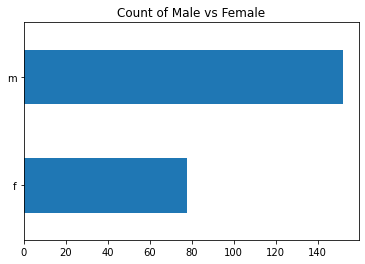

In [0]:
data['Sex'].value_counts().sort_values().plot.barh()
plt.title('Count of Male vs Female')

## Age

Average age: 51

The distribution is pretty even (equal number of people > and < 50 yrs old).

This is a contrast to the country's actual population distribution, where 89% of the population is < 55 yrs old ([source](https://www.indexmundi.com/philippines/age_structure.html)).

The distribution indicates that either it's mainly older people that are getting tested (makes sense if they're more likely to have symptoms), or old people are indeed more susceptible to catching the disease.


In [0]:
data['Age'].describe()

count    230.000000
mean      50.539130
std       16.737525
min       13.000000
25%       35.250000
50%       50.500000
75%       65.000000
max       88.000000
Name: Age, dtype: float64

Text(0.5, 1.0, 'Age Distribution')

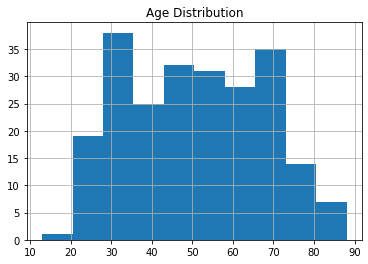

In [0]:
data['Age'].hist()
plt.title('Age Distribution')

Text(0.5, 1.0, 'Age Distribution')

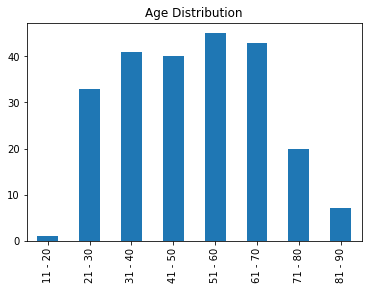

In [0]:
data['Age Group'].value_counts().sort_index().plot.bar()
plt.title('Age Distribution')

## Locations

In [0]:
data['Residence in the Philippines'].value_counts()

for_validation     54
quezon             34
san juan           23
makati             18
pasig              13
manila             12
marikina            7
mandaluyong         7
rizal               7
paranaque           6
las pinas           6
bulacan             5
cavite              5
muntinlupa          4
taguig              4
none                3
batangas            3
caloocan            3
pampanga            2
lanao del sur       2
pasay               2
negros oriental     2
davao de oro        1
tarlac              1
camarines sur       1
antipolo            1
cotabato            1
laguna              1
bataan              1
lucena              1
Name: Residence in the Philippines, dtype: int64

Text(0.5, 1.0, 'Confirmed cases per city / province')

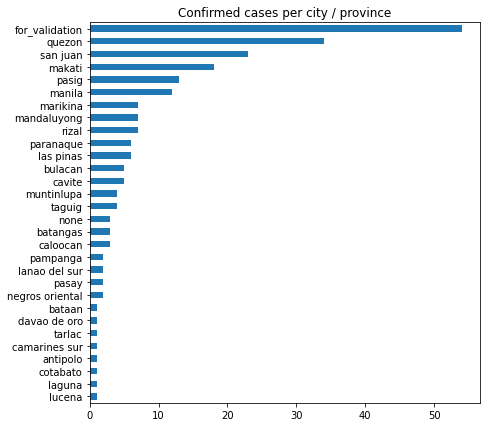

In [0]:
data['Residence in the Philippines'].value_counts().sort_values().plot.barh(figsize=(7,7))
plt.title('Confirmed cases per city / province')

## Nationality

From the validated cases, most are filipino (196 cases) (96%), and the rest are chinese (3 cases), thai (2 cases), taiwanese (1 case), and american (1 case)

In [0]:
data['Nationality'].value_counts()

filipino          185
for_validation     38
chinese             3
thai                2
american            1
taiwanese           1
Name: Nationality, dtype: int64

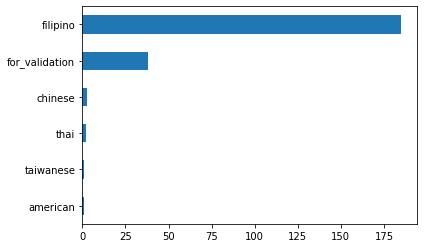

In [0]:
data['Nationality'].value_counts().sort_values().plot.barh()

# How did they get the disease?

## Travel history

72% of confirmed cases (w/ validation) did not have any travel history

In [0]:
data['Travel History'] == 'none'

0      False
1      False
2      False
3      False
4       True
       ...  
225    False
226    False
227    False
228    False
229    False
Name: Travel History, Length: 230, dtype: bool

In [0]:
data['Has Travel History'] = ~(data['Travel History'].dropna() == 'none')

In [0]:
data['Has Travel History'][data['Travel History'] != 'for_validation'].value_counts()

False    114
True      45
Name: Has Travel History, dtype: int64

Text(0.5, 1.0, 'Did the patient have travel history?')

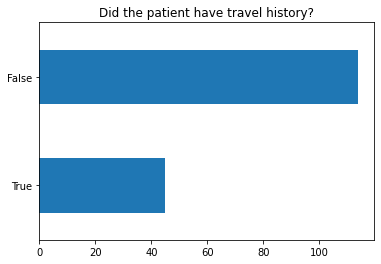

In [0]:
data['Has Travel History'][data['Travel History'] != 'for_validation'].value_counts().sort_values().plot.barh()
plt.title('Did the patient have travel history?')

## Patient links

26% of the confirmed cases have a link to another confirmed case.

In [0]:
data['Has Epi_Link'] = ~(data['Epi_Link'] == 'none')

In [0]:
data['Has Epi_Link'].value_counts()

False    170
True      60
Name: Has Epi_Link, dtype: int64

Text(0.5, 1.0, 'Does the patient have a link to a confirmed case?')

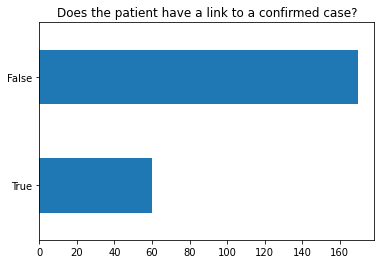

In [0]:
data['Has Epi_Link'].value_counts().sort_values().plot.barh()
plt.title("Does the patient have a link to a confirmed case?")

# How fast are cases growing?


In [0]:
data_valid = data[~data['Date of Lab Confirmation'].isin(['for_validation', 'none'])]

In [0]:
data_valid['Date of Lab Confirmation'] = data_valid['Date of Lab Confirmation'].apply(lambda x: datetime.strptime(x, "%d-%b-%y"))
data_valid['Week of Lab Confirmation'] = data_valid['Date of Lab Confirmation'] -  pd.to_timedelta(data_valid['Date of Lab Confirmation'].dt.dayofweek, unit='d')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
data_valid.groupby('Date of Lab Confirmation')['Case No.'].count()

Date of Lab Confirmation
2020-01-30     3
2020-03-05     2
2020-03-06     1
2020-03-08     4
2020-03-09    14
2020-03-10     9
2020-03-11    19
2020-03-12     2
2020-03-13    35
2020-03-14    12
2020-03-15    26
2020-03-16    47
2020-03-17     7
2020-03-18    19
Name: Case No., dtype: int64

## New cases

Text(0.5, 1.0, 'New Cases per Date')

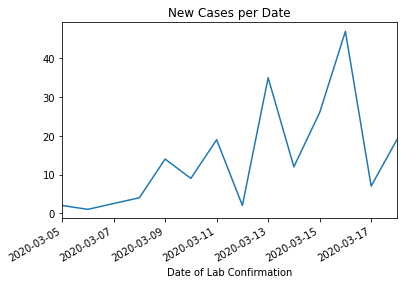

In [0]:
data_valid.groupby('Date of Lab Confirmation')['Case No.'].count().loc['2020-03-01':].plot(figsize=(12, 7))
plt.title('New Cases per Date')

Text(0.5, 1.0, 'New Cases per Week')

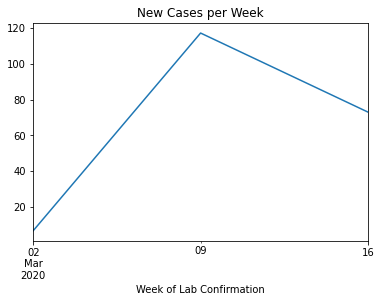

In [0]:
data_valid.groupby('Week of Lab Confirmation')['Case No.'].count().loc['2020-03-01':].plot(figsize=(12, 7))
plt.title('New Cases per Week')

## Cumulative cases

Text(0.5, 1.0, 'Cumulative Confirmed Cases per Date (Validated)')

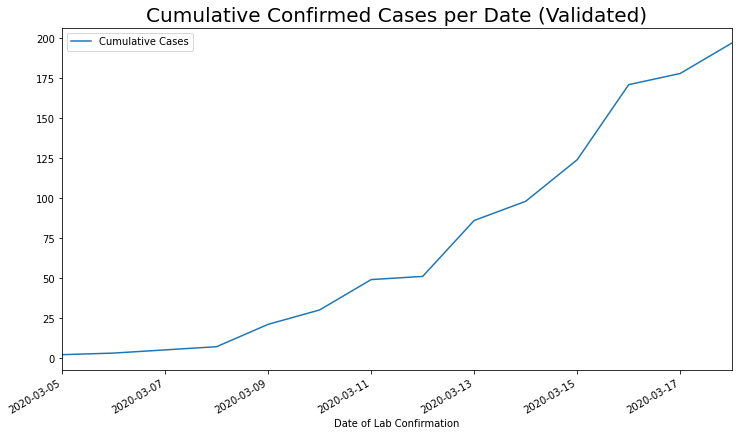

In [0]:
cum_cases = data_valid.groupby('Date of Lab Confirmation')[['Case No.']].count()
cum_cases.columns = ['Cumulative Cases']
cum_cases.loc['2020-03-01':].cumsum().plot(figsize=(12, 7))
plt.title('Cumulative Confirmed Cases per Date (Validated)', fontsize=20)

Text(0.5, 1.0, 'Cumulative Confirmed Cases per Week')

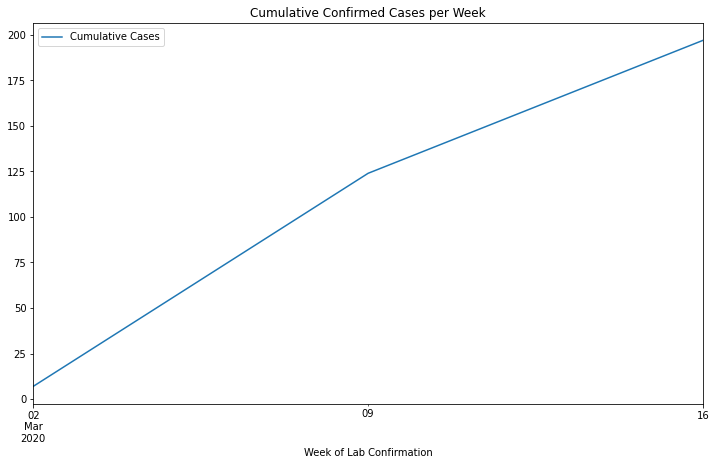

In [0]:
cum_cases_week = data_valid.groupby('Week of Lab Confirmation')[['Case No.']].count()
cum_cases_week.columns = ['Cumulative Cases']
cum_cases_week.loc['2020-03-01':].cumsum().plot(figsize=(12, 7))
plt.title('Cumulative Confirmed Cases per Week')

## New deaths

In [0]:
final_status_mask = ~data['Date of Final Status (recovered/expired)'].isin(['for_validation', 'none'])
final_status_data = data[final_status_mask]
final_status_data['Date of Final Status (recovered/expired)'] = final_status_data['Date of Final Status (recovered/expired)'].apply(lambda x: datetime.strptime(x, "%d-%b-%Y"))
final_status_data['Week of Final Status (recovered/expired)'] = final_status_data['Date of Final Status (recovered/expired)'] -  pd.to_timedelta(final_status_data['Date of Final Status (recovered/expired)'].dt.dayofweek, unit='d')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'New Deaths per Date')

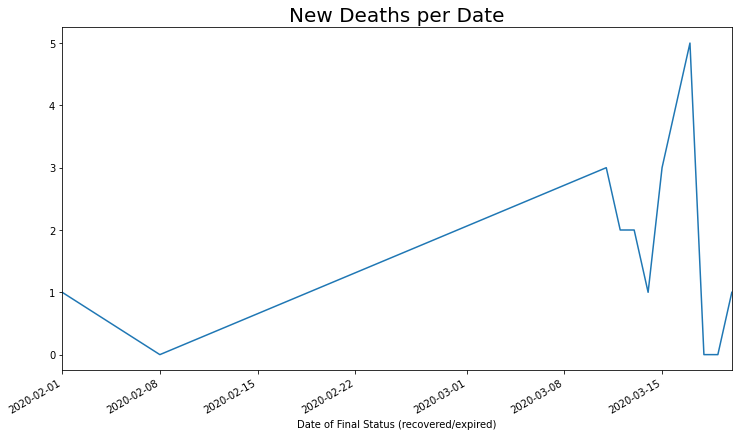

In [0]:
final_status_data.groupby('Date of Final Status (recovered/expired)')['died'].sum().plot(figsize=(12, 7))
plt.title('New Deaths per Date', fontsize=20)

## New recoveries

Text(0.5, 1.0, 'New Recoveries per Date')

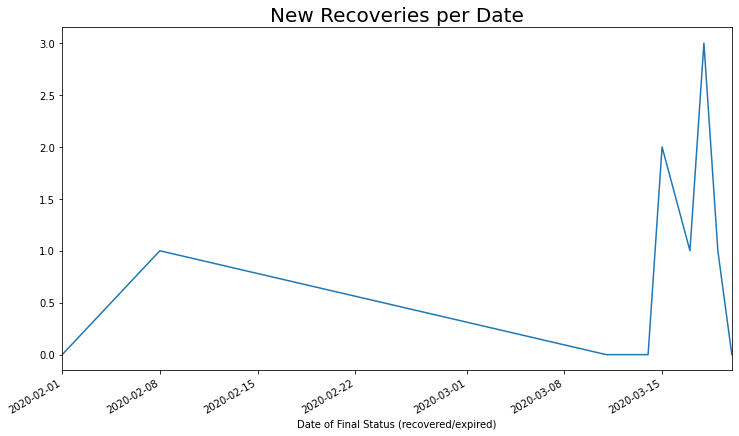

In [0]:
final_status_data.groupby('Date of Final Status (recovered/expired)')['recovered'].sum().plot(figsize=(12, 7))
plt.title('New Recoveries per Date', fontsize=20)

Text(0.5, 1.0, 'New Recoveries and Deaths per Date')

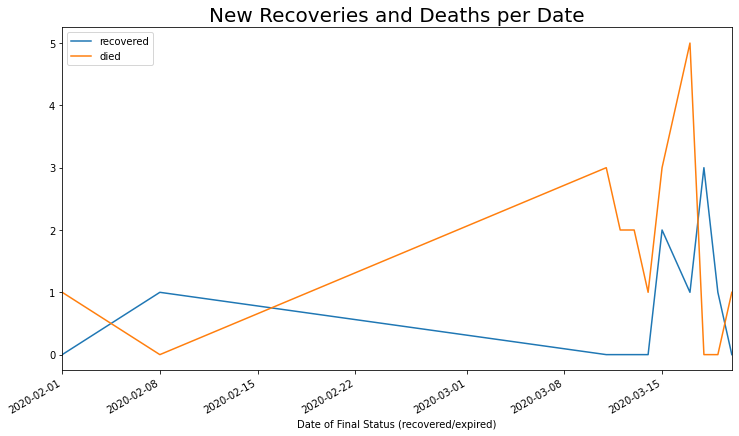

In [0]:
final_status_data.groupby('Date of Final Status (recovered/expired)')[['recovered', 'died']].sum().plot(figsize=(12, 7))
plt.title('New Recoveries and Deaths per Date', fontsize=20)

## Cumulative recoveries and deaths

Text(0.5, 1.0, 'Cumulative Recoveries and Deaths per Date')

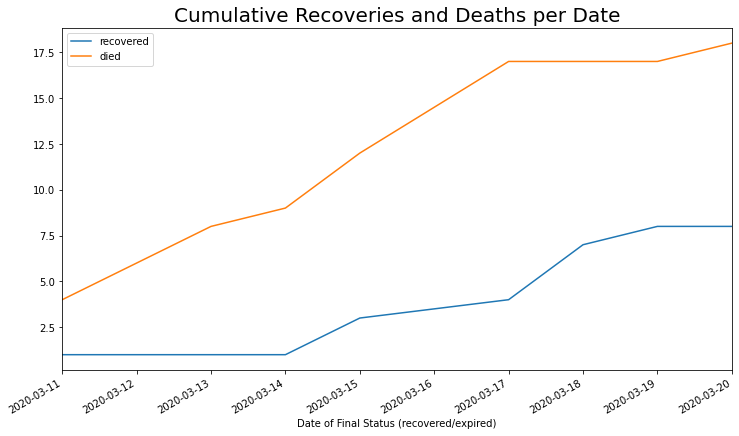

In [0]:
final_status_data.groupby('Date of Final Status (recovered/expired)')[['recovered', 'died']].sum().cumsum().loc['2020-03-01':].plot(figsize=(12, 7))
plt.title('Cumulative Recoveries and Deaths per Date', fontsize=20)

Text(0.5, 1.0, 'Cumulative Cases vs Recovered vs Died')

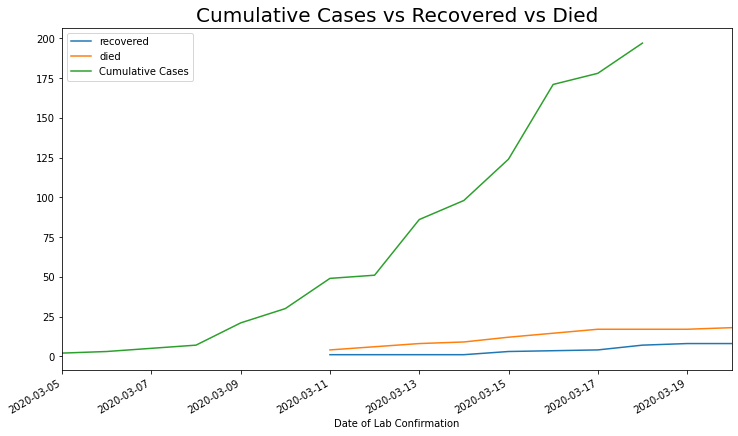

In [0]:
fig, ax = plt.subplots()

final_status_data.groupby('Date of Final Status (recovered/expired)')[['recovered', 'died']].sum().cumsum().loc['2020-03-01':].plot(figsize=(12, 7), ax=ax)
cum_cases.loc['2020-03-01':].cumsum().plot(figsize=(12, 7), ax=ax)
plt.title('Cumulative Cases vs Recovered vs Died', fontsize=20)

# Mapping the patients (to follow!)